In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from flows.base import Flow
from flows.affine import Planar, Radial
from flows.activation import PReLU
tfd = tfp.distributions
tf.compat.v1.enable_eager_execution()

In [2]:
k = 2
n_layers = 15
prelu = PReLU()
planar = Planar(k)
radial = Radial(k)
transform = planar
for i in range(n_layers):
    transform = planar(prelu(transform))

In [3]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros((k,)))

In [4]:
flow = Flow(base_dist, transform, learning_rate=1.0E-5, name='affine_gaussian')

In [5]:
x1_samples = tfd.Normal(loc=2.0, scale=4).sample(1000)
x2_samples = tfd.Normal(loc=0.5*x1_samples**2.0, scale=2.0*tf.ones(x1_samples.shape)).sample()
x_samples = tf.stack([x2_samples, x1_samples], axis=1)

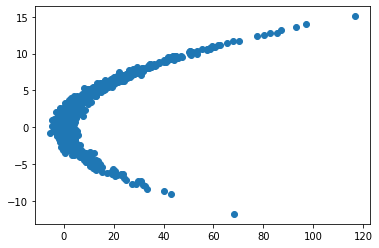

In [6]:
plt.scatter(x_samples[:,0], x_samples[:,1])

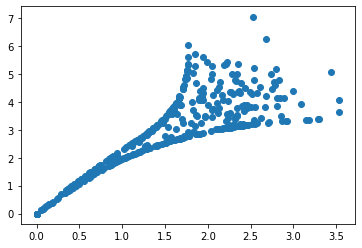

In [7]:
flow_dist_samples = flow.dist.sample(512)
plt.scatter(flow_dist_samples[:,0], flow_dist_samples[:,1])

In [8]:
print(x_samples[:1])
y = radial.forward(x_samples[:1])
print(y)
print(radial.inverse(y))
y = planar.forward(x_samples[:1])
print(y)
print(planar.inverse(y))

tf.Tensor([[ 1.7864032 -1.0705566]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 2.3308077 -2.0907962]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 1.7864032 -1.0705566]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 1.339369  -0.9068144]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 1.7864032 -1.0705566]], shape=(1, 2), dtype=float32)


In [9]:
print(radial.inverse_log_det_jacobian(radial.forward(x_samples[:1]), event_ndims=1))

tf.Tensor([[-3.4576952]], shape=(1, 1), dtype=float32)


In [ ]:
from tqdm import tqdm_notebook as tqdm
for i in tqdm(range(100000)):
    x_batch = x_samples[i*100 % len(x_samples-100):(i+1)*100%len(x_samples)]
    log_loss, grads = flow.train_on_batch(x_samples)
    if i % 100 == 0:
        #vars_grads = list(zip(map(flow.trainable_variables), map(lambda g: g.numpy(), grads)))
        print(f'(iteration {i}) log loss: {log_loss.numpy()}')
    if i % 1000 == 0:
        samples = flow.dist.sample(512)
        plt.scatter(samples[:,0], samples[:,1])
        plt.show()

W0908 19:37:30.769827 140433512466240 deprecation.py:323] From /home/brian/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
